# Homework 5 - Introduktion
Detta projekt visar hur man hämtar, bearbetar och visualiserar data från webben.
Först hämtas Nobelprisdata för fysik via REST API, och motivationssträngarna för varje pris extraheras och rengörs. Ett ordmoln skapas för att visa de vanligaste termerna och teman i prisutdelningarna.
Sedan skrapas webbplatsen Books to Scrape för de tre första katalogsidorna, där information om 60 böcker samlas in (UPC, titel, pris och betyg).
Projektet demonstrerar praktiska färdigheter i API-anrop, JSON-hantering, webbskrapning, textanalys och visualisering.

## Del A - REST API 

### A1: Webb-API-avläsning av Nobelprisdata: Strukturerad hämtning av fysikprisinformation

Denna uppgift går ut på att samla in historisk data om Nobelpristagare i fysik genom Nobelförsamlingens offentliga API. Syftet är att systematiskt hämta information om samtliga fysikpris som delats ut sedan priset instiftades, med särskilt fokus på de motivationer som angivits för varje prisutdelning.

Processen inleds med att koden skickar en HTTP-förfrågan till API:ets fysiskategori-slutpunkt. Varje API-svar sparas i dess råa JSON-format till lokal disk, vilket säkerställer reproducerbarhet och möjliggör vidare analys utan att behöva göra upprepade nätverksanrop.

Vid implementeringen dokumenteras alla använda frågeparametrar, inklusive kategoriinställning (fysik), eventuella årsspann, sidstorlek (limit) och offset-värden. Den slutliga datan struktureras genom att extrahera prislistan från API-svarets toppnivåobjekt, vilket ger en ren och användbar dataset för analys – att bearbeta och visualisera språkliga mönster i prisutdelningarnas motiveringar.
Koden följer etik och etikett. Det används lämpligt User-Agent samt time.sleep för att inte överbelasta servern. 

In [70]:
import os
import time #används för små pauser (sleep), för att inte överbelasta API:et.
import json
import requests #gör HTTP-anrop mot API (det är så vi hämtar JSON)
import pandas as pd
from collections import Counter
import re

from tqdm import tqdm  # visar en progressbar när vi hämtar flera sidor

#Visualisering
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

In [67]:

OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True) # skapar en mapp för att skapa datan 

OUT_COMBINED = os.path.join(OUT_DIR, "nobel_physics_combined_list.json") # skapar sökvägen till filen där vi sparar alla fysikpriser i en enda JSON-lista.
OUT_RAW_PAGES = os.path.join(OUT_DIR, "nobel_physics_raw_pages.json") # denna fil sparar varje sida vi hämtat från API:et
OUT_METADATA = os.path.join(OUT_DIR, "nobel_physics_metadata.json") # Här sparar vi metadata

BASE_URL = "https://api.nobelprize.org/2.1/nobelPrizes" #adressen för Nobelprisets officiella API v2.

params = {
    "nobelPrizeCategory": "physics",
    "limit": 25,
    "offset": 0
} # vi vill endast ha fysikpriser, 25 poster per sida, 0: börja på första sidan. 

HEADERS = {
    "User-Agent": "HW5-NobelFetcher/1.0 (student@school.edu) - educational use",
    "Accept": "application/json"
} # User-Agent anges så tjänsten vet det inte är en bot/attack, berättar att vi vill ha JSON 


def get_with_retries(url, params, headers, max_retries=5):
    backoff = 1.0
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=15)
            if r.status_code == 200:
                return r.json() # om lyckades returnera JSON-data.
            elif r.status_code in (429, 503):
                print(f"Status {r.status_code} — backoff {backoff}s (attempt {attempt})")
                time.sleep(backoff)
                backoff *= 2   # 429 = för många anrop, 503 = servern upptagen, vi väntar en liten stund och försöker igen
            else:
                r.raise_for_status() # kastar fel om API svarar med något oväntat (t.ex. 404).
        except requests.RequestException as e:
            print(f"Network error: {e} — backoff {backoff}s (attempt {attempt})")
            time.sleep(backoff)
            backoff *= 2 # nätverksfel 
    raise RuntimeError("Max retries reached for URL: " + url) # Om alla försök misslyckas


all_prizes = [] # alla fysikpriser ska lagras här
raw_pages = [] # vi sparar varje sida exakt som API:et gav den


# STARTAR HÄMTNING
print("Start fetching Nobel Prizes (category=physics)...")
pbar = tqdm(desc="pages fetched") # gör det tydligt när man laddar flera sidor.

while True:
    print(f"Requesting offset={params['offset']} limit={params['limit']}")
    data = get_with_retries(BASE_URL, params=params, headers=HEADERS) # Hämta en sida i taget: offset = 0, 25, 50, 75, …

    # Anpassa nyckeln efter API-svaret; vanligt är 'nobelPrizes'
    page_list = data.get("nobelPrizes") or data.get("prizes") or [] 
    if not isinstance(page_list, list):
        raise RuntimeError("Oväntat format: förväntade en lista under 'nobelPrizes' eller 'prizes'.") #API:et returnerar en lista i nobelPrizes. Om nyckeln inte finns → tom lista.

    raw_pages.append({"params": params.copy(), "response": data})  # Spara rå sida
    all_prizes.extend(page_list) #extend lägger till alla objekt från sidan i vår stora lista.

    pbar.update(1)

    # API ger färre än 25 på sista sidan då stoppar vi.
    if len(page_list) == 0 or len(page_list) < params['limit']:
        print("Sista sidan nådd eller inga fler poster.")
        break 

    # annars höj offset och fortsätt
    params['offset'] = params.get('offset', 0) + params['limit']
    time.sleep(0.4)   # Liten paus -  snällt mot API:et
    
pbar.close()

# SPARA RESULTAT
with open(OUT_COMBINED, "w", encoding="utf-8") as f:
    json.dump(all_prizes, f, ensure_ascii=False, indent=2)

with open(OUT_RAW_PAGES, "w", encoding="utf-8") as f:
    json.dump(raw_pages, f, ensure_ascii=False, indent=2)

metadata = {
    "endpoint": BASE_URL,
    "params_used": {
        "nobelPrizeCategory": "physics",
        "initial_limit": 25
    },
    "pages_fetched": len(raw_pages),
    "total_prizes_collected": len(all_prizes),
    "combined_file": OUT_COMBINED,
    "raw_pages_file": OUT_RAW_PAGES,
    "notes": "Simple offset/limit pagination; small retry/backoff implemented."
}
with open(OUT_METADATA, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Klart. Antal priser samlade:", len(all_prizes))
print("Sparade:", OUT_COMBINED)
print("Metadata:", OUT_METADATA)

Start fetching Nobel Prizes (category=physics)...


pages fetched: 0it [00:00, ?it/s]

Requesting offset=0 limit=25


pages fetched: 2it [00:00,  3.33it/s]

Requesting offset=25 limit=25


pages fetched: 3it [00:01,  2.57it/s]

Requesting offset=50 limit=25


pages fetched: 4it [00:01,  2.29it/s]

Requesting offset=75 limit=25


pages fetched: 5it [00:02,  2.17it/s]

Requesting offset=100 limit=25


pages fetched: 6it [00:02,  2.09it/s]

Requesting offset=125 limit=25


pages fetched: 7it [00:03,  2.07it/s]

Requesting offset=150 limit=25


pages fetched: 8it [00:03,  2.03it/s]

Requesting offset=175 limit=25


pages fetched: 9it [00:04,  2.02it/s]

Requesting offset=200 limit=25


pages fetched: 10it [00:04,  2.00it/s]

Requesting offset=225 limit=25


pages fetched: 11it [00:05,  2.00it/s]

Requesting offset=250 limit=25


pages fetched: 12it [00:05,  1.98it/s]

Requesting offset=275 limit=25


pages fetched: 13it [00:06,  1.99it/s]

Requesting offset=300 limit=25


pages fetched: 14it [00:06,  1.99it/s]

Requesting offset=325 limit=25


pages fetched: 15it [00:07,  1.99it/s]

Requesting offset=350 limit=25


pages fetched: 16it [00:07,  1.98it/s]

Requesting offset=375 limit=25


pages fetched: 17it [00:08,  1.99it/s]

Requesting offset=400 limit=25


pages fetched: 18it [00:08,  1.99it/s]

Requesting offset=425 limit=25


pages fetched: 19it [00:09,  1.98it/s]

Requesting offset=450 limit=25


pages fetched: 20it [00:09,  1.98it/s]

Requesting offset=475 limit=25


pages fetched: 21it [00:10,  1.97it/s]

Requesting offset=500 limit=25


pages fetched: 22it [00:10,  1.98it/s]

Requesting offset=525 limit=25


pages fetched: 23it [00:11,  1.99it/s]

Requesting offset=550 limit=25


pages fetched: 24it [00:11,  1.98it/s]

Requesting offset=575 limit=25


pages fetched: 25it [00:12,  1.98it/s]

Requesting offset=600 limit=25


pages fetched: 26it [00:12,  1.97it/s]

Requesting offset=625 limit=25


pages fetched: 27it [00:13,  1.97it/s]

Requesting offset=650 limit=25


pages fetched: 28it [00:13,  2.03it/s]

Requesting offset=675 limit=25
Sista sidan nådd eller inga fler poster.
Klart. Antal priser samlade: 682
Sparade: data/nobel_physics_combined_list.json
Metadata: data/nobel_physics_metadata.json


### A2: Textanalys av Nobelprismotiveringar: Extrahering och förbehandling av språkligt innehåll
Först identifieras och extraheras alla motivationssträngar från JSON-filen. Varje fysikpris kan ha flera motiveringar kopplade till olika pristagare.
Därefter genomgår den extraherade texten en omfattande förbehandling för att skapa en mer meningsfull ordstatistik. Detta inkluderar gemener - all text konverteras till små bokstäver, rensning - interpunktion och onödiga mellanslag tas bort samt filtrering - stoppord som inte tillför meningsfull information elimineras.

Ett domänspecifikt stoppordslista skapas för att undvika att ordmoln domineras av generiska termer som är självklara i kontexten. Detta säkerställer att visualiseringen framhäver innehållsrika orden.

In [73]:
with open("data/nobel_physics_combined_list.json", "r", encoding="utf-8") as f:
    nobel_data = json.load(f)

print(f"Antal priser i filen: {len(nobel_data)}")

motivations = []

for prize in nobel_data:
    laureates = prize.get("laureates", [])
    for laureate in laureates:
        motivation = laureate.get("motivation")
        if motivation:
            # Om motivation är en dict (med språk), ta engelska
            if isinstance(motivation, dict):
                text = motivation.get("en")  # ta engelsk text
                if text:
                    motivations.append(text)
            elif isinstance(motivation, str):
                motivations.append(motivation)

print(f"Antal motivationssträngar extraherade: {len(motivations)}")

Antal priser i filen: 682
Antal motivationssträngar extraherade: 1026
Exempel på motivationssträngar innan rensande
: ['in recognition of the extraordinary services he has rendered by the discovery of the laws of chemical dynamics and osmotic pressure in solutions']


In [76]:
# Lista med domän-specifika stoppord
domain_stopwords = {"nobel", "prize", "physics", "prizes", "laureate", "motivation", "discoveries","a", "the"}

cleaned_motivations = []

for text in motivations:
    text = text.lower()
    #Ta bort specialtecken (behåll bara bokstäver och mellanslag)
    text = re.sub(r"[^a-zåäö\s]", "", text)
    words = text.split()
    #Ta bort domän-specifika stoppord
    words = [w for w in words if w not in domain_stopwords]
    # Sätt ihop igen till en sträng
    cleaned_text = " ".join(words)
    cleaned_motivations.append(cleaned_text)
    
print("Exempel\n")
print("Motivationssträng innan rensande\n:", motivations[:1])
print("\nMotivationssträng efter rensande:\n", cleaned_motivations[:1])

Exempel

Motivationssträng innan rensande
: ['in recognition of the extraordinary services he has rendered by the discovery of the laws of chemical dynamics and osmotic pressure in solutions']

Motivationssträng efter rensande:
 ['in recognition of extraordinary services he has rendered by discovery of laws of chemical dynamics and osmotic pressure in solutions']


### A3: Visualisering av språkliga mönster i Nobelprismotiveringar: Ordmoln och frekvensanalys

I det slutliga steget skapas en visuell representation av de språkliga teman som dominerar Nobelprisutdelningarna i fysik genom ett ordmoln. Denna visualisering baseras på de förbehandlade och rensade motivationssträngarna från tidigare steg.

För att ge kvantitativ kontext presenteras en tabell med de 20 vanligaste termerna tillsammans med deras exakta förekomstantal. Denna kombination av visuell och numerisk information möjliggör en djupare förståelse av vilka begrepp och forskningsområden som historiskt har präglat fysikprisens motiveringar.

Totalt antal ord i motivationerna: 13383


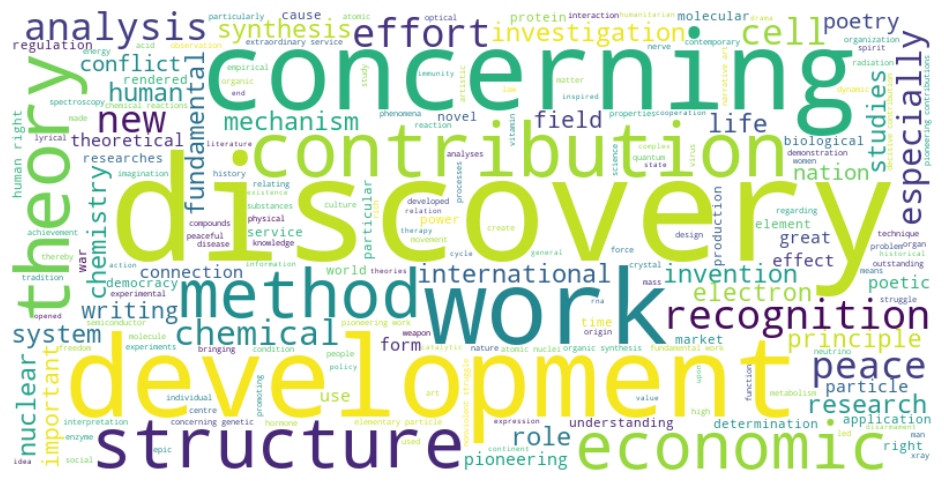

Tabell: 20 vanligaste orden:
of: 1285
for: 1138
and: 662
in: 446
their: 391
his: 376
to: 276
discovery: 208
concerning: 121
development: 110
work: 106
on: 101
which: 99
with: 98
by: 82
theory: 69
contributions: 60
has: 59
structure: 55
that: 54


In [78]:
# Skapa lista med alla ord (tokens)
all_tokens = []
for text in cleaned_motivations:
    all_tokens.extend(text.split())

print(f"Totalt antal ord i motivationerna: {len(all_tokens)}")

# WordCloud behöver en enda sträng
text_for_wordcloud = " ".join(all_tokens)

# Generera ordmoln
wc = WordCloud(width=800, height=400, background_color="white").generate(text_for_wordcloud)
# Visa ordmolnet
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

word_counts = Counter(all_tokens)
most_common_20 = word_counts.most_common(20)

# Visa tabellen
print("Tabell: 20 vanligaste orden:")
for word, count in most_common_20:
    print(f"{word}: {count}")

### Tolkning 

Ordmooln: Teman som återkommer är discovery, development, theory, electron, field, quantum  – visar att Nobelpriser i fysik handlar om grundläggande upptäckter inom fysik. Men vissa ord som economic, human, peace, human right och poetic visar att priser ges även för andra aspekter än bara ren fysik. 
Tabell:Innehåller ord som  visar återkommande teman, men också ord som 'his', 'work'  och liknande. Dessa kan självklart väljas bort om man nu vill ha en noggrann tabell med bara temaord. 

## Del B — Web Scraping
Denna uppgift innebär en systematisk webbskrapning av produktinformation från en online-bokhandel. Målet är att samla in specifika data för 60 böcker från webbplatsen https://books.toscarape.com/. Datainsamlingen omfattar de tre första katalogsidorna, där varje sida visar 20 böcker, totalt 60 böcker.

För varje bok ska fyra specifika attribut extraheras: den unika UPC-koden, boktiteln, det visade priset (inklusive valutasymbol) samt produktens stjärnbetyg uttryckt som ett ord (till exempel "Tre" för tre stjärnor). 

Processen implementeras med etiska och tekniska hänsynstaganden för att skapa en hållbar och respektfull skrapningslösning. Detta inkluderar användning av en tydlig användaragent, fördröjningar mellan förfrågningar för att inte överbelasta servern, samt robust felhantering för avvikelser på webbplatsen. Slutresultatet lagras i en tabell och sparats i ett CSV-format.

In [79]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE_URL = "https://books.toscrape.com/catalogue/"
HEADERS = {"User-Agent": "HW5-BookScraper/1.0 (student@example.com)"}

books_data = []

# Loop över sidor 1-3
for page in range(1, 4):
    page_url = f"{BASE_URL}page-{page}.html"
    print("Fetching:", page_url)
    r = requests.get(page_url, headers=HEADERS)
    soup = BeautifulSoup(r.content, "html.parser")
    
    # Hitta alla bokartiklar
    articles = soup.find_all("article", class_="product_pod")
    
    for article in articles:
        # Hämta boklänk
        a_tag = article.find("h3").find("a")
        rel_link = a_tag.get("href")
        # Om relativa länkar med "../", gör absolut
        book_url = BASE_URL + rel_link.replace("../../", "")
        
        # Gå in på detaljsidan
        r_book = requests.get(book_url, headers=HEADERS)
        soup_book = BeautifulSoup(r_book.content, "html.parser")
        
        # UPC
        upc_tag = soup_book.find("th", string="UPC")
        upc = upc_tag.find_next_sibling("td").text.strip() if upc_tag else "NA"

        # Titel
        title_tag = soup_book.find("div", class_="product_main").find("h1")
        title = title_tag.text.strip() if title_tag else "NA"

        # Pris
        price_tag = soup_book.find("p", class_="price_color")
        price = price_tag.text.strip() if price_tag else "NA"

        # Rating (klassnamn t.ex. "star-rating Three")
        rating_tag = soup_book.find("p", class_="star-rating")
        if rating_tag:
            rating_class = rating_tag.get("class", [])
            rating = next((r for r in rating_class if r != "star-rating"), "NA")
        else:
            rating = "NA"
        
        books_data.append({
            "upc": upc,
            "title": title,
            "price": price,
            "rating": rating
        })
        
        time.sleep(0.5)  # liten paus för att inte överbelasta servern

df_books = pd.DataFrame(books_data)  # Skapa DataFrame
df_books.to_csv("data/books_page1-3.csv", index=False, encoding="utf-8")  # Spara till CSV 

print("Totalt antal rader:", len(df_books))
df_books.head()


Fetching: https://books.toscrape.com/catalogue/page-1.html
Fetching: https://books.toscrape.com/catalogue/page-2.html
Fetching: https://books.toscrape.com/catalogue/page-3.html
Totalt antal rader: 60


,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five


# Reproducerbarhetsanteckningar

#### Miljökrav
- **Python 3.10+**
- **Jupyter Notebook**,
- **Paket: se filen 'requirements.txt'**

#### Reproducerbarhet
1. Installera Anaconda (eller Miniconda) som inkluderar Jupyter Notebook.
2. Installera nödvändiga Python-paket:
    ```bash
    pip install -r requirements.txt
    ```
3. Öppna projektet i Jupyter Notebook.
4. Kör notebooken **uppifrån och ner**.

#### Viktigt 
- Notera att notebooken är uppbyggd så att paket importeras i den första cellen samt variabler och funktioner definieras i de tidiga cellerna. För att alla celler ska fungera korrekt måste därför notebooken köras i ordning, uppifrån och ner. 
- API-anrop: Nobel-API-anrop samt skraping kan ta någon minut.
- Koden skapar en mapp 'data' och sparar all data som hämtas i denna mapp.
- Varje gång koden körs hämtas all data på nytt i till mappen 'data'
- Data som denna Notebook använder under tillfället för resultat som syns på Github följer med sparad i en extra mapp döpt 'data2025-12-07'